# EDA

We're building a data processing pipeline to reformat data for use in a convolutional neural network. The raw data includes DICOM images (2D) and text files with X,Y coordinates of a polygon mask that defines the inner and outer contours of the left ventricle of the heart. We've been provided with a script (parsing.py) which will use Pillow to take the X,Y coordinates of the polygon and create a filled pixel mask.

For the current work, I've been given a few functions that use pydicom and Pillow to actually extract the image and mask. The bulk of the work now is to find a good script to automatically walk through the file directories and associate the images with the masks. 

In [1]:
#!pip install Pillow, pydicom  # Additional packages to install 

In [2]:
from parsing import parse_contour_file, parse_dicom_file, poly_to_mask

In [3]:
DATA_DIR_BASE = r"../data/final_data/"               # Top-level directory for data
DICOMS_DIR_BASE = DATA_DIR_BASE + r"dicoms/"         # Top-level directory for dicoms
CONTOURS_DIR_BASE = DATA_DIR_BASE + r"contourfiles/" # Top-level directory for contour files
CONTOURS_SUB_DIR = r"/i-contours/"                    # Sub-directory ("i-contours" or "o-contours")

## Link File
We're provided with a CSV file to link the DICOM files with the contour files. Let's load it into a pandas dataframe and loop through.

In [4]:
import pandas as pd

In [5]:
dfLink = pd.read_csv(DATA_DIR_BASE + "link.csv")

In [6]:
dfLink

,patient_id,original_id
0,SCD0000101,SC-HF-I-1
1,SCD0000201,SC-HF-I-2
2,SCD0000301,SC-HF-I-4
3,SCD0000401,SC-HF-I-5
4,SCD0000501,SC-HF-I-6


In [7]:
import glob

def getFiles(dfLink, idx):
    dicomDirname = DICOMS_DIR_BASE + dfLink["patient_id"].iloc[idx] + "/"                    # DICOM Directory name
    contourDirname = CONTOURS_DIR_BASE + dfLink["original_id"].iloc[idx] + CONTOURS_SUB_DIR  # Contour Directory name

    dicomFiles   = glob.glob(dicomDirname + "*.dcm")   # Get the DICOM files within this directory
    contourFiles = glob.glob(contourDirname + "*.txt") # Get the contour files within this directory
    
    return dicomFiles, contourFiles

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs_and_masks(img, img_mask, imgDict):
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap="bone");
    plt.title("Original MRI of heart\nPatient #{}".format(imgDict["dicom"].PatientID));

    plt.subplot(1,2,2)
    plt.imshow(img, cmap="bone");
    plt.imshow(img_mask, alpha=0.3);

    plt.title("With inner diameter mask (yellow)");

    print("Pixel dimensions are {:.3f} x {:.3f} mm".format(imgDict["dicom"].PixelSpacing[0], 
                                                           imgDict["dicom"].PixelSpacing[1]))
    print("Slice thickness is {:.3f} mm".format(imgDict["dicom"].SliceThickness))

In [9]:
import fnmatch  # Filter file names
import re  # Import regular expressions to extract slice #
import os

def get_matching_slice(contourFilename, dicomFiles):
    
    sliceName = os.path.basename(os.path.splitext(contourFilename)[0])  # The mask name

    # Use regex to find the pattern xxxx-yyyy in the file name. Extract the yyyy and convert to int.
    # This will be the slice number
    sliceIdx = int(re.findall(r'\d{4}-\d{4}', sliceName)[0][-4:]) 

    dicomFilename = fnmatch.filter(dicomFiles, "*{}.dcm".format(sliceIdx))[0] # Find associated dicom image for slice
    
    return dicomFilename

In [10]:
def getMask(contourFilename, imgWidth, imgHeight, maskThreshold=0.5):
    '''
    contourFilename = absolute path to the contour file
    imgWidth = desired width
    imgHeight = desired height
    maskThreshold = [0,1] Sanity check. If mask is larger than this percentage, then contour might be bad.
    '''

    # Extract the polygon contour points
    polygonPoints = parse_contour_file(contourFilename)
    # Fill the polygon
    imgMask = poly_to_mask(polygonPoints, imgWidth, imgHeight)

    # Sanity check - What if the polygon is malformed? Let's check to make sure the mask isn't
    # more than a certain percentage of the entire image
    percentMask = imgMask.sum() / float(imgMask.shape[0] * imgMask.shape[1])
    if percentMask > maskThreshold:
        print("The mask is more than {} of the image. Please check if polygon is correct. {} {}".format(maskThreshold,
                                                                                                       dicomFilename, 
                                                                                                        sliceName))
        
    return imgMask

In [11]:
def get_imgs_and_masks(contourFilename, dicomFiles):
    dicomFilename = get_matching_slice(contourFilename, dicomFiles)

    imgDict = parse_dicom_file(dicomFilename)

    # Get the original DICOM image
    img = imgDict["pixel_data"]
    (imgHeight, imgWidth) = img.shape  # Get the image shape
    
    # Test:  The width and height should be the same that is listed in the DICOM header
    if (imgDict["dicom"].Rows!= imgHeight) | (imgDict["dicom"].Columns != imgWidth):
        print("Image size does not correspond to header {} {}".format(contourFilename, dicomFilename))

    # Get the associated mask for the image
    imgMask = getMask(contourFilename, imgWidth, imgHeight, maskThreshold=0.5)
    
    return img, imgMask, imgDict



## Sanity check
Let's plot a few of the extracted slices and masks to see if they make sense

In [12]:
dicomFiles, contourFiles = getFiles(dfLink, 0)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 10.000 mm


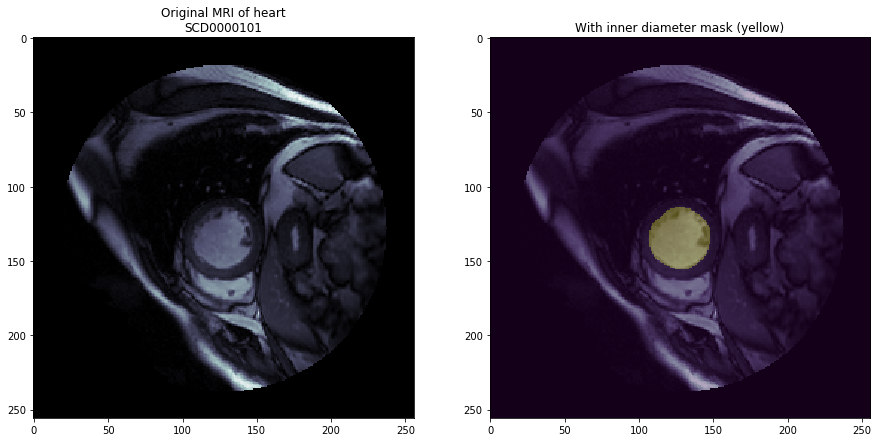

In [13]:
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[10], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 10.000 mm


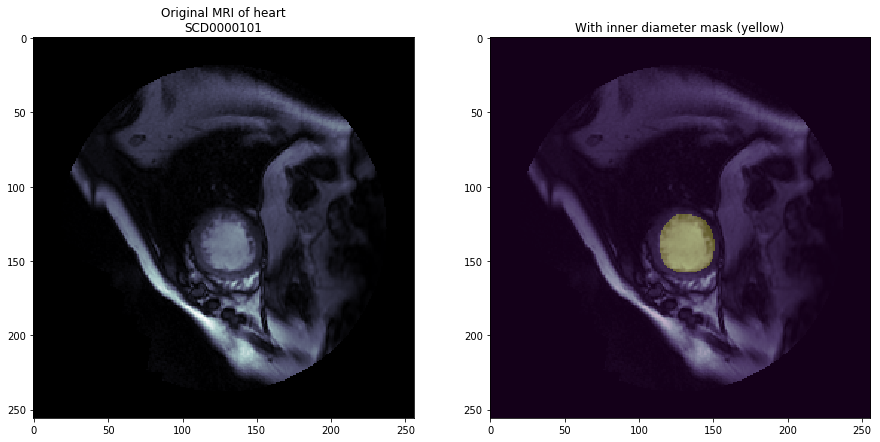

In [14]:
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[3], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 10.000 mm


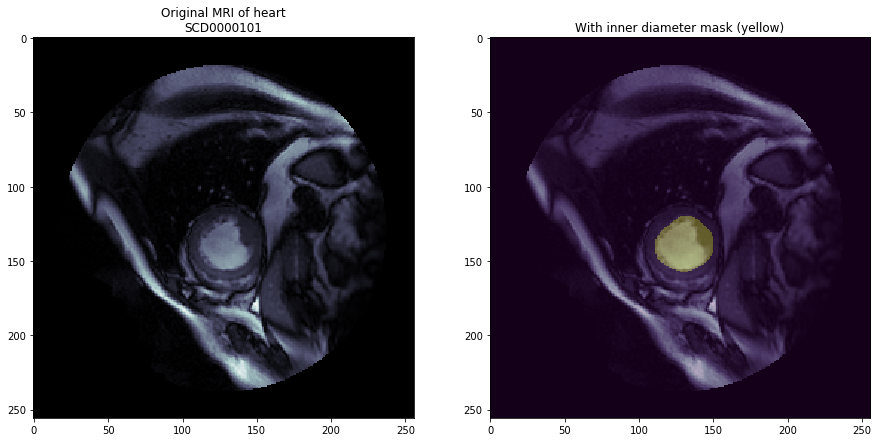

In [15]:
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[16], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 10.000 mm


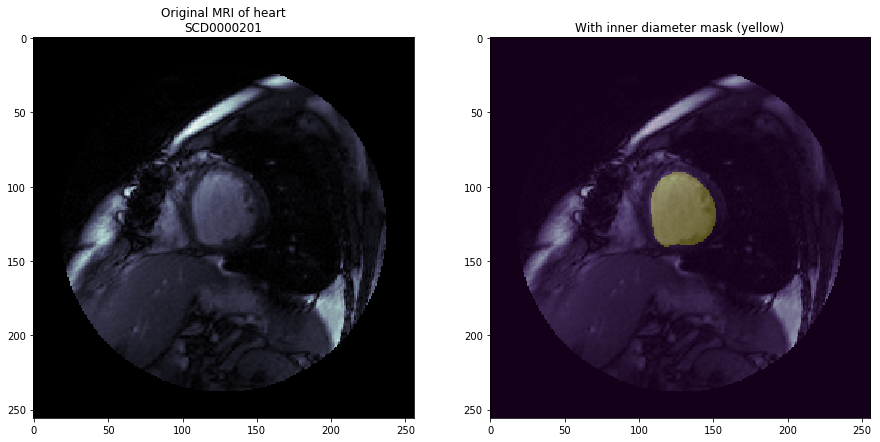

In [16]:
dicomFiles, contourFiles = getFiles(dfLink, 1)
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[16], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.289 x 1.289 mm
Slice thickness is 8.000 mm


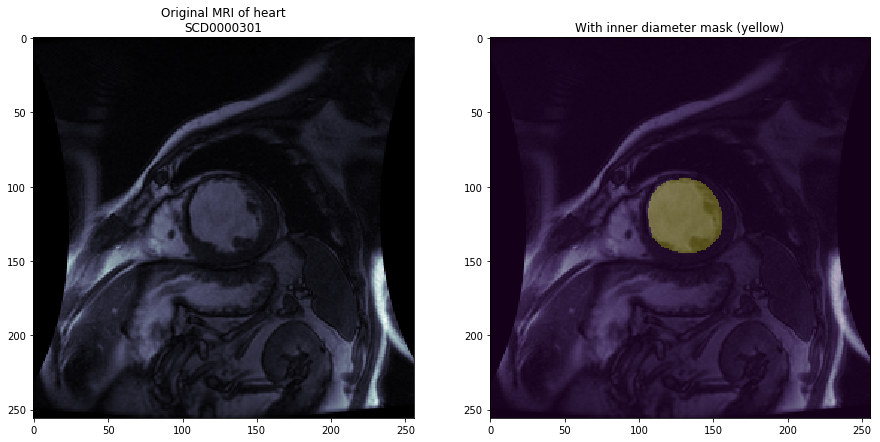

In [17]:
dicomFiles, contourFiles = getFiles(dfLink, 2)
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[7], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 8.000 mm


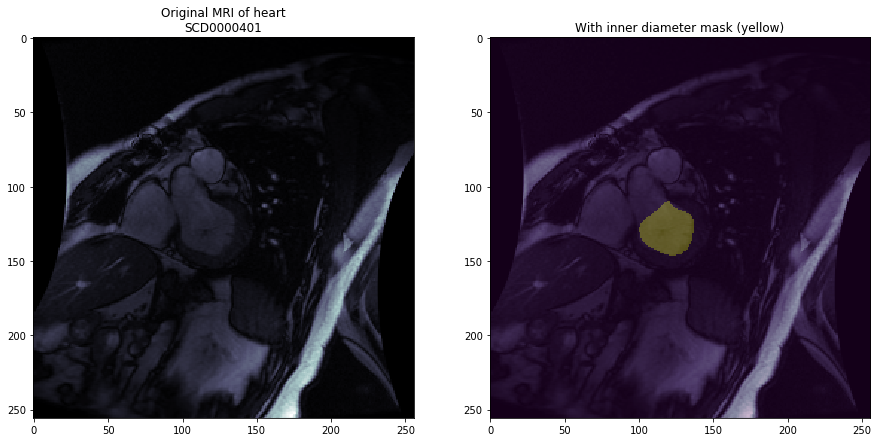

In [18]:
dicomFiles, contourFiles = getFiles(dfLink, 3)
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[4], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 8.000 mm


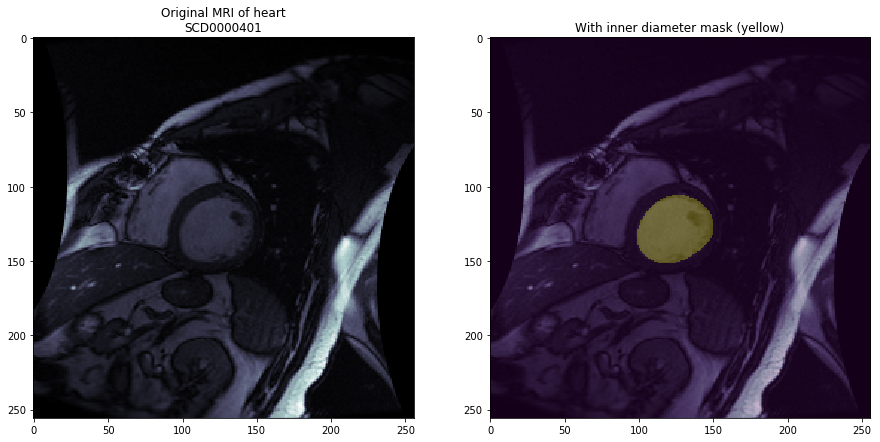

In [19]:
dicomFiles, contourFiles = getFiles(dfLink, 3)
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[13], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

Pixel dimensions are 1.367 x 1.367 mm
Slice thickness is 8.000 mm


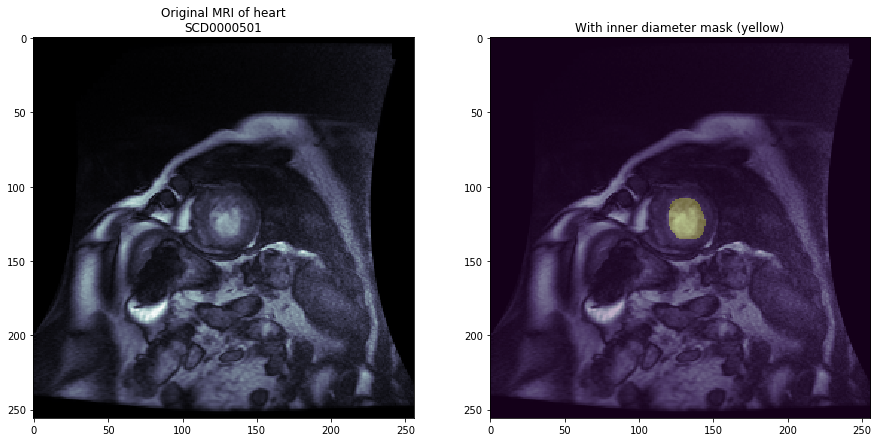

In [20]:
dicomFiles, contourFiles = getFiles(dfLink, 4)
img, imgMask, imgDict = get_imgs_and_masks(contourFiles[19], dicomFiles)
plot_imgs_and_masks(img, imgMask, imgDict)

## After building the pipeline, please answer the following questions:

+ How did you verify that you are parsing the contours correctly?

    I've plotted the original image next to the combined image/mask to give a visual sanity check of the pipeline. The extracted masks look correct, but we note that subset 2 (patient SCD0000301) has a slightly different image resolution (1.289 mm per pixel) than the other 5 (which are 1.376). They all seem to be 256 x 256 image. I'd suggest using Simple ITK or OpenCV to normalize the images to the same pixel resolution and then crop as needed to get the 256 x 256 pixels. Obviously the pixel masks for those will also need to be modified to compensate for the change in resolution.
    
    Further, I added a test in the getMask() function to test whether the mask is taking up too much of the image. This might not be needed, but I thought there might be a corner case where the polygon points are corrupted and Pillow would end up making a mask that was far too large. If I had more time, I'd consider adding a Hough transform to detect ellipses in the image and verify that there is just one ellipse.
    
    Note that the 4-digit number in the contour filename seems to point to the slice from the DICOM. Also, there are slices that do not have associated masks. In the final output, I can simply fill these with empty masks and store the array as a sparse matrix to save on disk size.


+ What changes did you make to the code, if any, in order to integrate it into our production code base?

    I added the entire dicom dictionary to return because I thought it important to check the resolution of the images. Ideally, the model should be working from images of uniform pixels/mm.
    
    In the process_dicom_to_hdf5.py script, I create an extensible end-to-end script that iteratively goes through the data directory, extracts the DICOM image and mask, and saves these to an HDF5 file. We can use the HDF5 file for training our convolutional neural network by using the HDF5 batch loader.